Размещение нейросети на сервере Anvil

Найдите любой другой сервис, подходящий для развертывания моделей и реализуйте произвольную задачу (разбор данного задания будет осуществлен на сервисе https://anvil.works/ для задачи классификации базы Ирисов)

P.s. вы можете взять любой другой сервис и любую другую задачу

In [ ]:
# Основа для модели нейронной сети
from tensorflow.keras.models import Model 

# Стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization 

# Оптимизатор Adam
from tensorflow.keras.optimizers import Adam 

# Дополнительные утилиты keras
from tensorflow.keras import utils 

# Инструменты для построения графиков
import matplotlib.pyplot as plt 

# Инструменты для работы с изображениями
from tensorflow.keras.preprocessing import image 

# Инструменты для работы с массивами
import numpy as np 

# Системные инструменты
import time, random, gdown, os

# Дополнительные инструменты для работы с изображениями
from PIL import Image 

# Дополнительные инструменты визуализации
import seaborn as sns
sns.set_style('darkgrid')

In [ ]:
# Загрузка датасета из облака

gdown.download('https://storage.googleapis.com/datasets_ai/Base/15_segmentation/airplane_456x256.zip', None, quiet=True)
#gdown.download('https://storage.googleapis.com/datasets_ai/Base/15_segmentation/airplane_912x512.zip', None, quiet=True)
#gdown.download('https://storage.googleapis.com/datasets_ai/Base/15_segmentation/airplane_1920x1080.zip', None, quiet=True)

'airplane_456x256.zip'

In [ ]:
# Распаковка архива

!unzip -qo airplane_456x256.zip

In [ ]:
# Глобальные параметры

IMG_WIDTH = 256               # Ширина картинки 
IMG_HEIGHT = 456              # Высота картинки 
CLASS_COUNT = 2               # Количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

In [ ]:
# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')): 

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))               
        
    # Вывод времени загрузки картинок выборки    
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title, 
                                                                  time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list)) 

    return image_list

In [ ]:
# Функция для просмотра изображений из набора

def show_imageset(image_list,  # выборка изображений
                  n            # количество картинок для просмотра
                  ):

    fig, axs = plt.subplots(1, n, figsize=(25, 10))       # Создание полотна из n графиков

    # Вывод в цикле n случайных изображений
    for i in range(n): 
        img = random.choice(image_list)                   # Выборка случайного фото для отображения
        axs[i].axis('off')
        axs[i].imshow(img)                                # Отображение картинки

    plt.show()                                            # Отрисовка изображений

In [ ]:
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'original', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'original', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.22 с
Количество изображений: 931
Проверочная выборка загружена. Время загрузки: 0.01 с
Количество изображений: 50


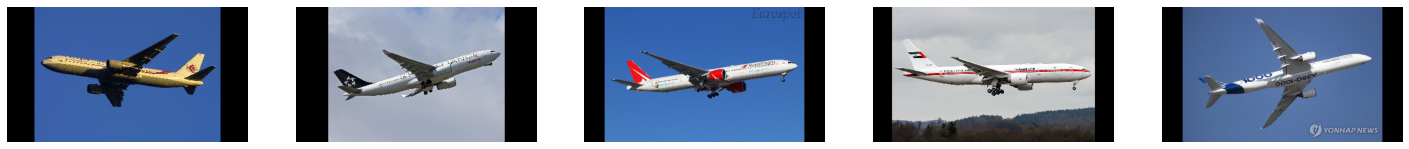

In [ ]:
# Просмотр входных изображений из обучающего набора

show_imageset(train_images, 5)

In [ ]:
# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segment', 'Обучающая')
val_segments = load_imageset(VAL_DIRECTORY, 'segment', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.20 с
Количество изображений: 931
Проверочная выборка загружена. Время загрузки: 0.01 с
Количество изображений: 50


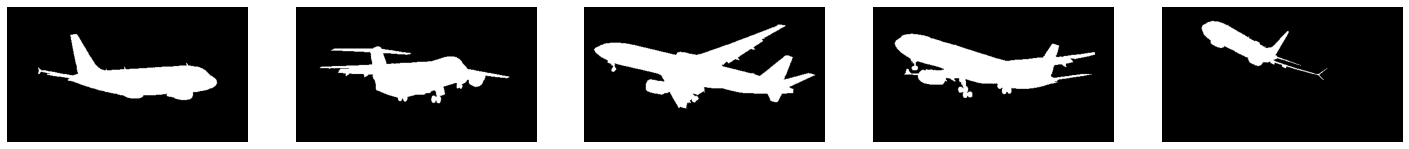

In [ ]:
# Просмотр сегментированных изображений из обучающего набора

show_imageset(train_segments, 5)

In [ ]:
# Цвета пикселов сегментированных изображений

AIRPLANE = (255, 255, 255)      # Самолет (белый)
BACKGROUND = (0, 0, 0)          # Фон (черный)

In [ ]:
CLASS_LABELS = (AIRPLANE, BACKGROUND)

In [ ]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений 
                 ):

    result = []
  
    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картики
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS): 
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i 

        result.append(y)
  
    return np.array(result)

In [ ]:
# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений 
                 ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')
        
        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)
  
    return np.array(result)

In [ ]:
# Формирование обучающей выборки

x_train = []                          # Cписок под обучающую выборку

for img in train_images:              # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_train.append(x)                 # Добавление элемента в x_train

x_train = np.array(x_train)           # Перевод всей выборки в numpy
print(x_train.shape)                  # Форма x_train

(931, 256, 456, 3)


In [ ]:
# Формирование проверочной выборки

x_val = []                            # Cписок под проверочную выборку

for img in val_images:                # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_val.append(x)                   # Добавление элемента в x_train

x_val = np.array(x_val)               # Перевод всей выборки в numpy
print(x_val.shape)                    # Форма x_train

(50, 256, 456, 3)


In [ ]:
# Преобразование сегментов в метки классов

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

(931, 256, 456, 1)
(50, 256, 456, 1)


In [ ]:
def unet(class_count,   # количество классов
         input_shape    # форма входного изображения
         ): 
  
    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 2 '''
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 3 '''
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 4 '''
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out 

    ''' UP 2 '''
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 3 '''
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 4 '''
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)      # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # Возвращаем сформированную модель
    return model

In [ ]:
# Создание модели и вывод сводки по архитектуре

model_unet = unet(CLASS_COUNT, 
                  (IMG_WIDTH, IMG_HEIGHT, 3))

model_unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 456, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 256, 456, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 456, 64  256        ['block1_conv1[0][0]']           
 alization)                     )                                                             

In [ ]:
# Обучение модели

history = model_unet.fit(x_train, y_train, 
                         epochs=50, batch_size=12,
                         validation_data=(x_val, y_val)) 

Epoch 1/50
78/78 [==============================] - 123s 1s/step - loss: 0.1301 - sparse_categorical_accuracy: 0.9602 - val_loss: 0.3131 - val_sparse_categorical_accuracy: 0.8834
Epoch 2/50
78/78 [==============================] - 92s 1s/step - loss: 0.0417 - sparse_categorical_accuracy: 0.9865 - val_loss: 0.3353 - val_sparse_categorical_accuracy: 0.8803
Epoch 3/50
78/78 [==============================] - 95s 1s/step - loss: 0.0323 - sparse_categorical_accuracy: 0.9890 - val_loss: 0.1097 - val_sparse_categorical_accuracy: 0.9536
Epoch 4/50
78/78 [==============================] - 95s 1s/step - loss: 0.0262 - sparse_categorical_accuracy: 0.9908 - val_loss: 0.0406 - val_sparse_categorical_accuracy: 0.9854
Epoch 5/50
78/78 [==============================] - 96s 1s/step - loss: 0.0221 - sparse_categorical_accuracy: 0.9923 - val_loss: 0.0397 - val_sparse_categorical_accuracy: 0.9867
Epoch 6/50
78/78 [==============================] - 95s 1s/step - loss: 0.0228 - sparse_categorical_accuracy:

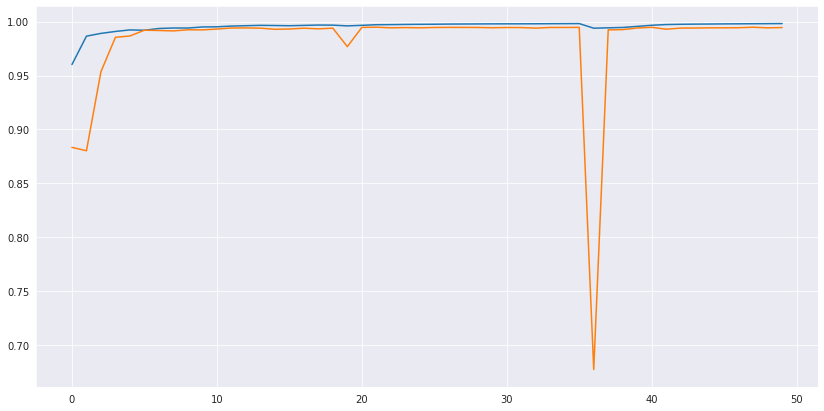

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

In [ ]:
# Функция визуализации процесса сегментации изображений, модифицированная для вывода по списку индексов

def process_images(model,                       # обученная модель
                   count=1,                     # количество случайных картинок для сегментации
                   indexes=None,                # список индексов изображений в проверочной выборке
                   ):
  
    if indexes is None:
        # Генерация случайного списка индексов в количестве count между (0, len(x_val)
        indexes = np.random.randint(0, len(x_val), count)
    else:
        count = len(indexes)

    # Вычисление предсказания сети для картинок с отобранными индексами
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)

    # Подготовка цветов классов для отрисовки предсказания
    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 10)) 
    
    # Отрисовка результата работы модели
    for i in range(count):
        # Отображение на графике в первой линии предсказания модели
        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')

        # Отображение на графике во второй линии сегментированного изображения из y_val
        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1 ,i].axis('off')

        # Отображение на графике в третьей линии оригинального изображения
        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2 ,i].axis('off')

    plt.show() 

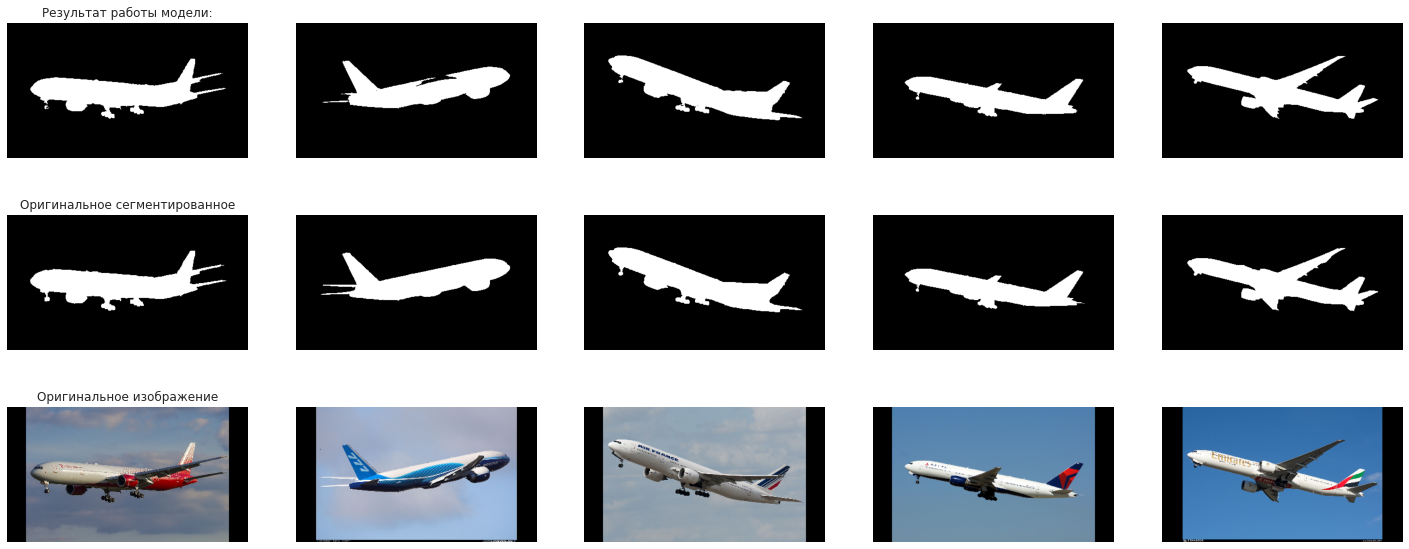

In [ ]:
# Отображение результатов работы модели

process_images(model_unet, 5)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Пересохранение обученной модели полностью (веса и архитектура)
model_unet.save('/content/drive/MyDrive/NN/model_UNET_airplanes.h5')

In [ ]:
import keras
model_unet=keras.models.load_model('/content/drive/MyDrive/NN/model_UNET_airplanes.h5')

In [ ]:
!pip install anvil-uplink

     |████████████████████████████████| 64 kB 1.8 MB/s 
     |████████████████████████████████| 51 kB 174 kB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45229 sha256=c642efb8d522a2b32b1a5f828e08362c4bdf96316cec78229066db341eb7262b
  Stored in directory: /root/.cache/pip/wheels/29/ea/7d/3410aa0aa0e4402ead9a7a97ab2214804887e0f5c2b76f0c96
Successfully built ws4py


In [ ]:
import anvil.server
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [ ]:
anvil.server.connect("LSLG7CAUKNV73PDSNNYWFNK3-AWNFR24B23HKT3U6")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default environment" as SERVER


In [ ]:
def get_prediction(test_img):
    """Evaluate the model on a PIL image"""
    #x = image.img_to_array(img)
    #img.resize((basewidth,hsize), Image.ANTIALIAS)

    test_img = test_img.resize((IMG_HEIGHT,IMG_WIDTH), resample=Image.BICUBIC)
    test_arr = image.img_to_array(test_img)
    test_arr = np.expand_dims(test_arr, axis=0)
    #test_arr /= 255.0
    #print(test_arr.shape)
    predict = model_unet.predict(test_arr)
    #print(predict.shape)
    predict = np.argmax(predict, axis=-1)
    orig = labels_to_rgb(predict[..., None])
    #print(type(orig))
    return orig

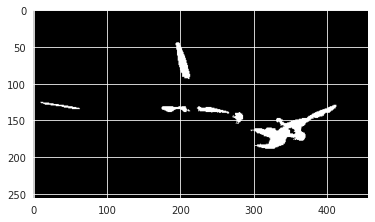

<class 'anvil.BlobMedia'>


KeyboardInterrupt: ignored

In [ ]:
import anvil.media
@anvil.server.callable
def classify_image(file):
    #print(type(file))
    with anvil.media.TempFile(file) as f:
        img = load_img(f)
    #print(type(img))
    SegmentedImage = get_prediction(img)[0]
    #print(type(SegmentedImage),len(SegmentedImage),SegmentedImage.shape)
    plt.imshow(SegmentedImage)
    plt.show() 
    img = Image.fromarray(SegmentedImage, 'RGB')
    img.save('my.png')
    #img.show()
    media=anvil.media.from_file('my.png')#, [content_type], [name])

    print(type(media))
    return media
anvil.server.wait_forever()